In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import bq_helper
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

set_matplotlib_formats('retina')
%matplotlib inline

In [3]:
from google.cloud import bigquery
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


In [39]:
query = """
    SELECT 
        FORMAT("%'d",COUNT(DISTINCT fullVisitorId)) AS users,
        FORMAT("%'d",SUM(totals.visits)) AS visits,
        FORMAT("%'d",SUM(totals.pageviews)) AS pageviews,
        FORMAT("%'d", SUM(totals.transactions)) AS transactions,
        SUM(totals.transactionRevenue)/1000000 AS revenue

    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20170801'
        AND totals.totalTransactionRevenue IS NOT NULL
        
"""
safe_query_job = client.query(query)
revenue = safe_query_job.to_dataframe()
revenue

,users,visits,pageviews,transactions,revenue
0,"8,315","9,537","256,659","9,970",1259373.44


In [42]:
query1 = """
    SELECT 
        _TABLE_SUFFIX as date,
        FORMAT("%'d",COUNT(DISTINCT fullVisitorId)) AS users,
        FORMAT("%'d",SUM(totals.visits)) AS visits,
        FORMAT("%'d",SUM(totals.pageviews)) AS pageviews,
        FORMAT("%'d", SUM(totals.transactions)) AS transactions,
        SUM(totals.transactionRevenue)/1000000 AS revenue

    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20170801'
        AND totals.totalTransactionRevenue IS NOT NULL
    GROUP BY date     
        
"""
safe_query_job = client.query(query1)
revenue1 = safe_query_job.to_dataframe()
revenue1

,date,users,visits,pageviews,transactions,revenue
0,20170619,39,39,934,41,8976.59
1,20161105,20,20,649,20,1153.61
2,20170219,15,15,595,21,1051.69
3,20170519,39,39,"1,012",41,4377.22
4,20170111,17,17,569,18,1369.64
...,...,...,...,...,...,...
300,20170205,12,12,330,12,762.64
301,20161005,44,44,"1,225",45,4829.02
302,20170330,37,38,957,38,4281.41
303,20170115,6,6,118,6,98.88


In [43]:
revenue1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          305 non-null    object 
 1   users         305 non-null    object 
 2   visits        305 non-null    object 
 3   pageviews     305 non-null    object 
 4   transactions  305 non-null    object 
 5   revenue       305 non-null    float64
dtypes: float64(1), object(5)
memory usage: 14.4+ KB


In [49]:
revenue1['year'] = pd.Series(revenue1['date']).str[0:4]
revenue1['month'] = pd.Series(revenue1['date']).str[4:6]
revenue1['day'] = pd.Series(revenue1['date']).str[6:8]
revenue1

,date,users,visits,pageviews,transactions,revenue,year,month,day
0,20170619,39,39,934,41,8976.59,2017,06,19
1,20161105,20,20,649,20,1153.61,2016,11,05
2,20170219,15,15,595,21,1051.69,2017,02,19
3,20170519,39,39,"1,012",41,4377.22,2017,05,19
4,20170111,17,17,569,18,1369.64,2017,01,11
...,...,...,...,...,...,...,...,...,...
300,20170205,12,12,330,12,762.64,2017,02,05
301,20161005,44,44,"1,225",45,4829.02,2016,10,05
302,20170330,37,38,957,38,4281.41,2017,03,30
303,20170115,6,6,118,6,98.88,2017,01,15


In [51]:
revenue1['transactions'] = pd.Series(revenue1['transactions']).str.replace(',', '').astype(int)
revenue1['visits'] = pd.Series(revenue1['visits']).str.replace(',', '').astype(int)
revenue1['AOV'] = revenue1['revenue']/revenue1['transactions']
revenue1['CR'] = revenue1['transactions']/revenue1['visits']*100
revenue1['RPV'] = revenue1['AOV']*revenue1['CR']
revenue1

,date,users,visits,pageviews,transactions,revenue,year,month,day,AOV,CR,RPV
0,20170619,39,39,934,41,8976.59,2017,06,19,218.941220,105.128205,23016.897436
1,20161105,20,20,649,20,1153.61,2016,11,05,57.680500,100.000000,5768.050000
2,20170219,15,15,595,21,1051.69,2017,02,19,50.080476,140.000000,7011.266667
3,20170519,39,39,"1,012",41,4377.22,2017,05,19,106.761463,105.128205,11223.641026
4,20170111,17,17,569,18,1369.64,2017,01,11,76.091111,105.882353,8056.705882
...,...,...,...,...,...,...,...,...,...,...,...,...
300,20170205,12,12,330,12,762.64,2017,02,05,63.553333,100.000000,6355.333333
301,20161005,44,44,"1,225",45,4829.02,2016,10,05,107.311556,102.272727,10975.045455
302,20170330,37,38,957,38,4281.41,2017,03,30,112.668684,100.000000,11266.868421
303,20170115,6,6,118,6,98.88,2017,01,15,16.480000,100.000000,1648.000000


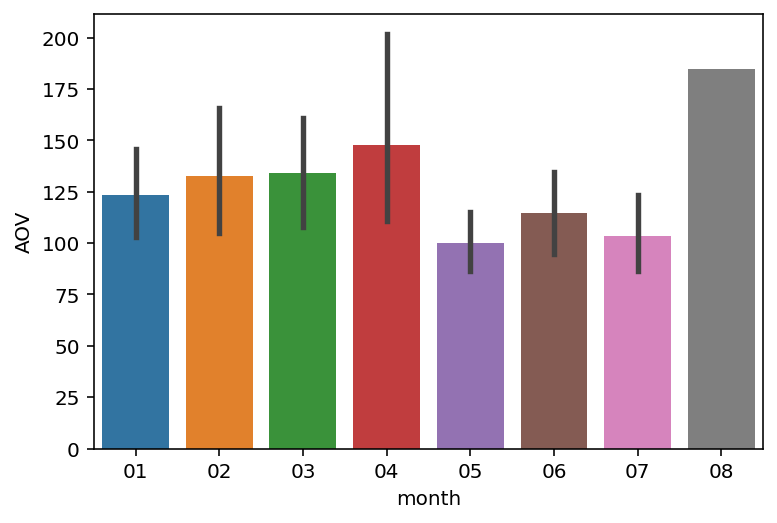

In [58]:
sns.barplot(x='month',
            y='AOV',
            data=revenue1[revenue1.year=='2017'])

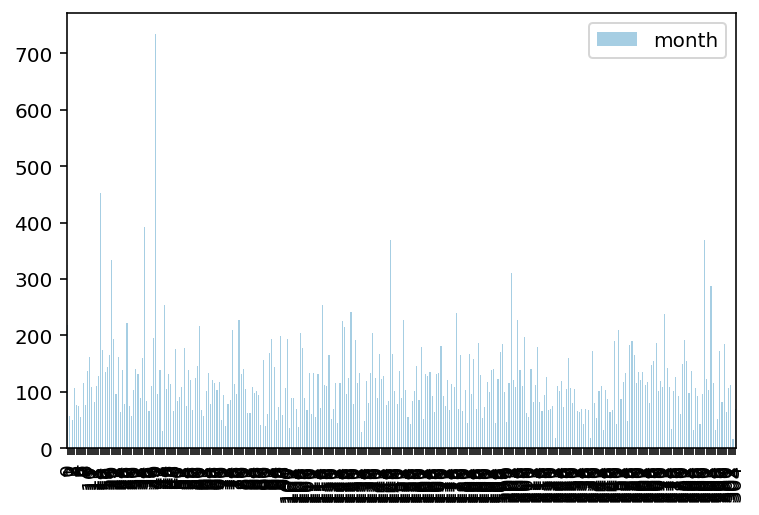

In [65]:
revenue1.plot(x='month', y='AOV', kind='line', label='month', colormap='Paired', use_index=False)

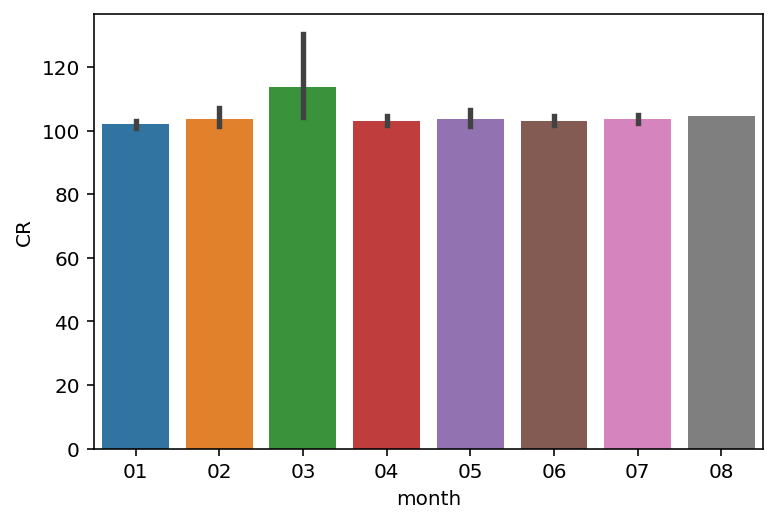

In [59]:
sns.barplot(x='month',
            y='CR',
            data=revenue1[revenue1.year=='2017'])

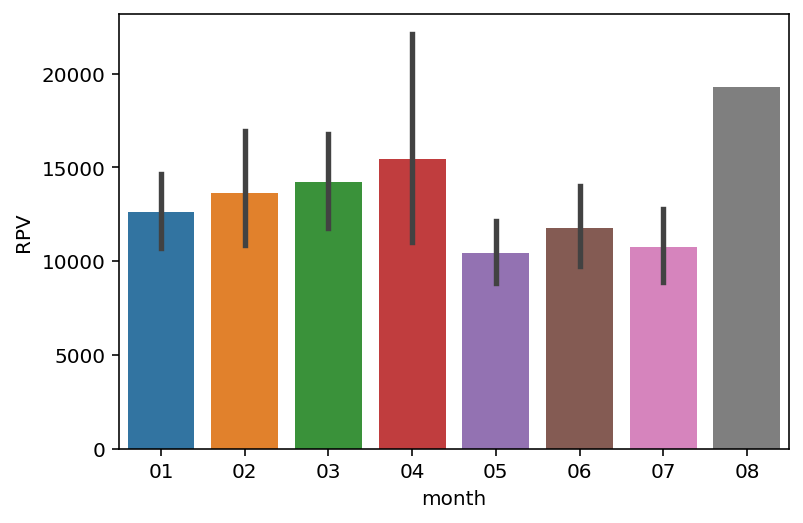

In [60]:
sns.barplot(x='month',
            y='RPV',
            data=revenue1[revenue1.year=='2017'])

In [53]:
revenue1.describe()

,visits,transactions,revenue,AOV,CR,RPV
count,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000
mean,31.268852,32.688525,4129.093246,119.408296,104.415313,12403.815355
std,15.467916,16.441824,3368.480064,71.235260,13.305356,7579.979814
min,3.000000,3.000000,70.540000,16.480000,100.000000,1648.000000
25%,19.000000,20.000000,1629.980000,74.830526,100.000000,7724.416667
50%,30.000000,32.000000,3816.780000,108.517407,102.040816,11257.862069
75%,39.000000,41.000000,5272.760000,139.845455,105.128205,14582.406250
max,87.000000,89.000000,27150.610000,733.800270,307.692308,84845.656250


In [50]:
# traffic by month
query = """
    SELECT 
        DATE_TRUNC(PARSE_DATE('%Y%m%d',date), MONTH) AS month,
        SUM(totals.transactions) AS transactions,
        SUM(totals.visits) AS visits,        
        SUM(totals.transactionRevenue)/1000000 AS revenue

    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND totals.totalTransactionRevenue IS NOT NULL
    GROUP BY 1
    ORDER BY 1
        
"""
safe_query_job = client.query(query)
df_1 = safe_query_job.to_dataframe()
df_1.head(3)

,month,transactions,visits,revenue
0,2016-10-01,919,872,113329.07
1,2016-11-01,955,919,119013.87
2,2016-12-01,1440,1385,153856.76


In [40]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   users         1 non-null      object 
 1   visits        1 non-null      object 
 2   pageviews     1 non-null      object 
 3   transactions  1 non-null      object 
 4   revenue       1 non-null      float64
dtypes: float64(1), object(4)
memory usage: 168.0+ bytes


In [13]:
revenue['transactions']

0    9,970
Name: transactions, dtype: object

In [26]:
revenue['transactions'] = pd.Series(revenue['transactions']).str.replace(',', '').astype(int)

In [30]:
revenue['visits'] = pd.Series(revenue['visits']).str.replace(',', '').astype(int)

In [28]:
revenue['AOV'] = revenue['revenue']/revenue['transactions']

In [33]:
revenue['CR'] = revenue['transactions']/revenue['visits']*100

In [35]:
revenue['RPV'] = revenue['AOV']*revenue['CR']

In [36]:
revenue

,users,visits,pageviews,transactions,revenue,AOV,CR,RPV
0,"8,315",9537,"256,659",9970,1259373.44,126.316293,104.540212,13205.132012


In [ ]:
revenue['CR'] = 